## Multi-task problem: colored MNIST

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, TensorDataset


import matplotlib.pyplot as plt

%matplotlib inline

### Colored [MNIST Dataset](https://pytorch.org/docs/stable/torchvision/datasets.html#mnist)
* Handwritten digits with 10 classes
* Size of each image: 28x28 pixels 
* 50 000 data examples in training set, 10 000 examples in validation set, 10 000 in test set
* We colorize each image with a random color within 7 (red, green, blue, magenta, yellow, cyan, white)
* Each image has two labels: the number it represents (10 classes) and the color of the number (7 classes)

In [2]:
# Given a loaded MNIST dataset, create a colozied version of it
def colorize_dataset(dataset):
    # array of colors
    COLORS = torch.tensor([
        [1.0, 0.0, 0.0], # 0 RED
        [0.0, 1.0, 0.0], # 1 GREEN
        [0.0, 0.0, 1.0], # 2 BLUE
        [1.0, 1.0, 0.0], # 3 YELLOW
        [1.0, 0.0, 1.0], # 4 MAGENTA
        [0.0, 1.0, 1.0], # 5 CYAN
        [1.0, 1.0, 1.0], # 6 WHITE
    ])
    N = len(dataset)
    images = dataset.data.view(N, 1, 28, 28)
    labels = dataset.targets.view(N, 1)
    color_labels = torch.randint(0, 6, (N,))
    colorized_images = images * COLORS[color_labels, :].view(N,3,1,1)
    full_labels = torch.cat((labels, color_labels.view(N, 1)), dim=1)
    return TensorDataset(colorized_images, full_labels)
    

In [3]:
# Loading MNIST dataset from torchvision.dataset
dataset = torchvision.datasets.MNIST(root='data/',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

dataset = colorize_dataset(dataset)

0it [00:00, ?it/s]

9920512it [00:04, 2159824.95it/s]                             


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 126159.77it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:01, 868861.92it/s]                              
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


8192it [00:00, 47500.85it/s]            


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


In [4]:
print("The shape of the dataset is :", dataset.tensors[0].size())

The shape of the dataset is : torch.Size([60000, 3, 28, 28])


In [5]:
# split the dataset into training and validation sets
train_set, val_set = random_split(dataset, [50000, 10000])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'image label: tensor([9, 2])')

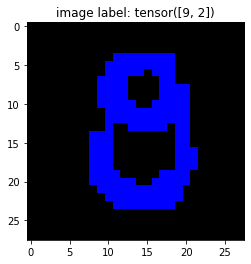

In [6]:
sample_index = 80

plt.imshow(dataset[sample_index][0].permute(1, 2, 0), interpolation='nearest')
plt.title("image label: {}".format(dataset[sample_index][1]))

### Training the neural network

In [107]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        self.l1 = nn.Linear(28*28*3, 28*28*6)
        self.l2 = nn.Linear(28*28*6, 28*28*6)
        # The input size is 28*28. For a standard classification task, the output size should be the same as the number of classes
        self.l_number = nn.Linear(28*28*6, 10)
        # However here we deal with 2 tasks: the network outputs 2 labels, so there are two "last" layers in parallel
        self.l_color = nn.Linear(28*28*6, 7)
        
    def forward(self, inputs):
        h = inputs.view(-1, 28*28*3)
        h = torch.relu(self.l1(h))
        
        h = self.l2(h)
        h = torch.relu(self.l2(h))
        # Use softmax as the activation function for the last layer(s)
        output_number = F.softmax(self.l_number(h), dim=1)
        output_color = F.softmax(self.l_color(h), dim=1)
        
        return (output_number, output_color)

In [108]:
# Create the model: 
model = Model()

# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 10

# Use mean squared loss function 
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [109]:
# define a function for training
def train(num_epochs, batch_size, criterion, optimizer, model, dataset):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
            (y_number, y_color) = model(images)
            
            # One-hot encoding or labels so as to calculate MSE error:
            number_onehot = F.one_hot(labels[:,0], 10).float()
            color_onehot = F.one_hot(labels[:,1], 7).float()
            
            loss = criterion(y_number, number_onehot) + criterion(y_color, color_onehot)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

In [111]:
train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set)

KeyboardInterrupt: 

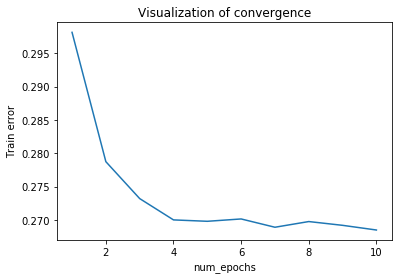

In [96]:
# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.savefig('3_dense_layer_conv.png')
plt.show()

### Evaluate the model on the validation set

In [12]:
# Calculate the accuracy to evaluate the model
def accuracy(dataset, model):

    with torch.no_grad():
        number_correct = 0
        color_correct = 0
        both_correct = 0
        dataloader = DataLoader(dataset)
        for images, labels in dataloader:
            images = images.view(-1, 28*28)
            (y_number, y_color) = model(images)
            _, number_predicted = torch.max(y_number.data, 1) 
            number_correct += (number_predicted == labels[:, 0]).sum()
            _, color_predicted = torch.max(y_color.data, 1) 
            color_correct += (color_predicted == labels[:, 1]).sum()
            both_correct += ((color_predicted == labels[:, 1]) and (number_predicted == labels[:, 0])).sum()

    print('Accuracy of the model for numbers : {:.2f} %'.format(100*number_correct.item()/ len(dataset)))
    print('Accuracy of the model for colors : {:.2f} %'.format(100*color_correct.item()/ len(dataset)))
    print('Accuracy of the model for both : {:.2f} %'.format(100*both_correct.item()/ len(dataset)))

In [13]:
accuracy(val_set, model)

Accuracy of the model for numbers : 46.25 %
Accuracy of the model for colors : 33.05 %
Accuracy of the model for both : 15.67 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Prediction: number=9, color=3')

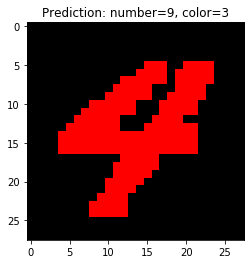

In [14]:
val_index = 66

(image, label) = val_set[val_index]
(y_number, y_color) = model(image)
_, number_prediction = torch.max(y_number.data, 1)
_, color_prediction = torch.max(y_color.data, 1)

plt.imshow(image.permute(1, 2, 0), interpolation='nearest')
plt.title("Prediction: number=%d, color=%d" % (number_prediction, color_prediction))

### Exercise 1: Impact of the architecture of the model
Define your own class `Model` to improve the predictions:

* The convolutional layer can be a good choice to deal with images. Replace nn.Linear with [nn.Conv2d](https://pytorch.org/docs/stable/nn.html#conv2d).
* Try to add more layers (1, 2, 3, more ?)
* Change the number of neurons in hidden layers (5, 10, 20, more ?)
* Try different activation functions such as [sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.
* __Your network generates two different outputs, how much weight-sharing (i.e. how many common layers) between these two paths is appropriate?__

In [84]:
class Model1(nn.Module):
    
    def __init__(self):
        super(Model1, self).__init__()
        self.conv1 = nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.l_number = nn.Flatten()
        self.l_color = nn.Flatten()
        # The input size is 28*28. For a standard classification task, the output size should be the same as the number of classes
        self.l_number = nn.Conv2d(3,16,5)
        # However here we deal with 2 tasks: the network outputs 2 labels, so there are two "last" layers in parallel
        self.l_color = nn.Conv2d(3,16,5)
        self.l_number = nn.Linear(16*28*28, 10)
        self.l_color = nn.Linear(16*28*28, 7)
        
    def forward(self, inputs):
        h = inputs.view(-1, 28*28*3)
        # Use softmax as the activation function for the last layer(s)
        output_number = F.relu(self.l_number(h), dim=1)
        output_color = F.softmax(self.l_color(h), dim=1)
        
        return (output_number, output_color)

In [85]:
# Create the model: 
model = Model1()

# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 10

# Use mean squared loss function 
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [86]:
train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set)

RuntimeError: size mismatch, m1: [10 x 2352], m2: [12544 x 10] at /Users/distiller/project/conda/conda-bld/pytorch_1573049287641/work/aten/src/TH/generic/THTensorMath.cpp:197

In [81]:
class MultiLayerModel(nn.Module):
    def __init__(self, n_hidden_layers=0, n_neurons=2, hidden_activations=torch.relu, 
                 output_activation=torch.softmax):
        super(MultiLayerModel, self).__init__()
        
        self.n_layers = n_hidden_layers
        
        if type(n_neurons)==int:
            self.n_neurons = [3] + [n_neurons for _ in range(n_hidden_layers)]
        else:
            assert type(n_neurons)==list
            assert len(n_neurons)==n_hidden_layers
            self.n_neurons = [3] + n_neurons
        
        for i in range(self.n_layers):
            input_dim = self.n_neurons[i]
            output_dim = self.n_neurons[i+1]
            setattr(self,
                    "layer_{}".format(i+1),
                    nn.Conv2d(input_dim, output_dim))
        
        self.l_number = nn.Conv2d(self.n_neurons[-1], 16,(3,3))
        self.l_color = nn.Conv2d(self.n_neurons[-1], 16,(3,3))
        
        self.hidden_activations = hidden_activations
        self.output_activation = output_activation
    
    def forward(self, inputs):
        x = inputs
        for i in range(self.n_layers):
            x = getattr(self, "layer_{}".format(i+1))(x)
            if i < self.n_layers - 1:
                x = self.hidden_activations(x)
        output_number = self.output_activation(self.l_number(x))
        output_color = self.output_activation(self.l_color(x))
        
        
        return (output_number, output_color)
       
    

In [82]:
class CustomModel(nn.Module):
    
    def __init__(self, layers=['dense_512'], with_softmax=True, hidden_activation=torch.relu):
        super().__init__()
        assert isinstance(layers, list)
        for layer in layers: assert isinstance(layer, str) 
        self.with_softmax = with_softmax
        self.hidden_activation = hidden_activation
        self.n_hidden_layers = len(layers)
        self.input_shapes = None
        self.needs_input_flat = True
        
        for i, layer in enumerate(layers):
            params = layer.split('_')
            layer_type, params = params[0], params[1:]
            assert layer_type in ['dense', 'conv2d', 'maxpool2d', 'flatten']
            
            
            if layer_type == 'dense':
                if i == 0:
                    self.needs_input_flat = True
                    self.input_shapes = [28*28]
                n_neurons = int(params[0])
                in_shape = self.input_shapes[-1]
                layer = nn.Linear(in_shape, n_neurons)
                self.input_shapes.append(n_neurons)
            
            elif layer_type == 'conv2d':
                if i == 0:
                    self.needs_input_flat = False
                    self.input_shapes = [(28,28,1)]
                in_shape = self.input_shapes[-1]
                assert isinstance(in_shape, tuple)
                assert len(in_shape) == 3
                in_width, in_height, in_channels = in_shape
                n_channels, kernel_size, stride = int(params[0]), int(params[1]), int(params[2])
                layer = nn.Conv2d(in_channels=in_channels,
                                  out_channels=n_channels, 
                                  kernel_size=kernel_size, 
                                  stride=stride)
                self.input_shapes.append(
                    (floor((in_width - kernel_size)/stride + 1),
                     floor((in_height - kernel_size)/stride + 1),
                     n_channels
                    )
                )
            elif layer_type == 'flatten':
                layer = nn.Flatten()
                in_shape = self.input_shapes[-1]
                out_shape = in_shape[0]*in_shape[1]*in_shape[2]
                self.input_shapes.append(out_shape)
            
            elif layer_type == 'maxpool2d':
                in_shape = self.input_shapes[-1]
                assert isinstance(in_shape, tuple)
                assert len(in_shape) == 3
                in_width, in_height, _ = in_shape
                
                kernel_size = int(params[0])
                layer = nn.MaxPool2d(kernel_size=kernel_size)
                self.input_shapes.append(
                        (floor((in_width - kernel_size)/kernel_size + 1),
                         floor((in_height - kernel_size)/kernel_size + 1),
                         n_channels
                        )
                    )

            setattr(self, 'hidden_{}'.format(i), layer)
            
        self.l_number = nn.Linear(self.input_shapes[-1], 10)
        self.l_color = nn.Linear(self.input_shapes[-1], 7)
    
    def forward(self, x):
        for i in range(self.n_hidden_layers):
            layer = getattr(self, "hidden_{}".format(i))
            x = self.hidden_activation(layer(x))
            
        x_number = self.l_number(x) 
        x_color = self.l_color(x)
        if self.with_softmax:
            x_number = F.softmax(x_number, dim=1)
            x_color = F.softmax(x_color, dim=1)
        return (x_number,x_color)

In [48]:
def plot_convergence(model_name, train_error, val_acc):
    plt.plot(range(1, len(train_error) + 1), train_error)
    plt.title("Train error for {} - Validation accuracy: {:.2f}%".format(model_name, val_acc*100))
    plt.xticks(range(1, len(train_error) + 1))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    
    
def plot_image(model, val_set, val_index=66):
    (image, label) = val_set[val_index]
    image = image.to(device)
    if model.needs_input_flat:
        image = image.view(-1, 28*28*3)
    else:
        image = image.view(-1, 3, 28, 28)
    output = model(image)
    _, prediction = torch.max(output.data, 1)
    plt.imshow(image.cpu().view(3, 28, 28), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title("Prediction label: %d" % prediction)

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU available")

In [83]:
epochs = 8
batch_size = 100

architectures = {
    "1 layer, 50 neurons": (["dense_50"]*1, 0.05),
    "3 layers, 50 neurons": (["dense_50"]*3, 0.1),
    "5 layers, 50 neurons": (["dense_50"]*5, 0.5)
}

results = {}

for name, (arch, lr) in architectures.items():
    model = CustomModel(layers=arch, with_softmax=True)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    loss = nn.MSELoss()
    print("Training model: ", name)
    train_errors = train(num_epochs, batch_size, criterion, optimizer, model, train_set)
    val_acc = compute_accuracy(model, val_set)
    plt.subplot(121)
    plot_convergence(model_name=name, train_error=train_errors, val_acc=val_acc)
    plt.subplot(122)
    plot_image(model=model, val_set=val_set)
    plt.show()
    print("-"*20)


Training model:  1 layer, 50 neurons


RuntimeError: size mismatch, m1: [8400 x 28], m2: [784 x 50] at /Users/distiller/project/conda/conda-bld/pytorch_1573049287641/work/aten/src/TH/generic/THTensorMath.cpp:197

In [39]:
n_hidden_layers=0
n_neurons=4

# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 10

# Training criterion. This one is a mean squared error (MSE) loss between the output
# of the network and the target label
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
model = CustomModel(n_hidden_layers, n_neurons)
print('The model used is :\n', model)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set)

The model used is :
 MultiLayerModel(
  (l_number): Conv2d(2352, 10, kernel_size=(3, 3), stride=(1, 1))
  (l_color): Conv2d(2352, 7, kernel_size=(3, 3), stride=(1, 1))
)


RuntimeError: Given groups=1, weight of size 10 2352 3 3, expected input[10, 3, 28, 28] to have 2352 channels, but got 3 channels instead

### Exercise 2: Impact of the optimizer
Retrain the model by using different parameters of the optimizer; you can change its parameters in the cell initializing it, after the definition of your model.

* Use different batch sizes, from 10 to 1 000 for instance
* Try different values of the learning rate (between 0.001 and 10), and see how these impact the training process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

### Exercise 3: Impact of the loss function
The MSE error is rarely used in this case. The cross entropy loss can be a better choice for multi-classification problems. In pytorch, the cross entropy loss is defined by [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html#crossentropyloss). Replace the MSE loss by this one to observe its impact.

**Note:** In order to use nn.CrossEntropyLoss correctly, don't add an activation function to the last layer of your network. And one-hot encoding is no longer needed to calculate the loss, delete the encoding procedures in function `train`.   

### Exercise 4: Prediction on test set

Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.

In [ ]:
# Loading MNIST test set from torchvision.dataset
test_set = torchvision.datasets.MNIST(root='data/',
                                         train=False,
                                         transform=transforms.ToTensor(),
                                         download=False)
test_set = colorize_dataset(test_set)

In [ ]:
accuracy(test_set, model)